# Fantasy Premier League team optimisation
### Intro

Attempt to use some sort of AI to generate the optimal team, along with transfer and chip strategy eventually. Data from https://github.com/vaastav/Fantasy-Premier-League/.

Player points prediction is probably the most technical element of a task like this. It would involve not only gathering the most common data but also searching for alternative data that could improve accuracy, such as betting odds for various markets or even something as stupid as the tweets of the player may improve accuracy. There are a number of available models currently out there, put together by people who have thought a lot more about the problem than I have. The plan is to probably use the FFS or fplreview projections for the upcoming season. 

As such, initially this project is purely an optimisation problem based on the predicted points and any other factors useful for creating a team. The optimisation will firstly be tried using `pyomo` but may need to manually write the optimisation ysing `pytorch` to utilise GPU capabilities depending on how long the first method takes. 

First grabbing the data:
```
git clone https://github.com/vaastav/Fantasy-Premier-League.git
```

### Data prep

In [1]:
import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error
#from pulp import LpMaximize, LpProblem, LpVariable, lpSum
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import chardet
import os

The dataset only has expected points from 2020-21 so I'll only consider data from then for the optimisation part

In [2]:
import pandas as pd
import os
import chardet

def load_and_bind_csvs(base_directory, seasons):
    # Initialize an empty dictionary to hold dataframes by their columns set
    dataframes_by_columns = {}

    # Loop over each season
    for season in seasons:
        gws_directory = os.path.join(base_directory, season, 'gws')
        if not os.path.exists(gws_directory):
            print(f"Directory does not exist: {gws_directory}")
            continue

        # Loop over all files in the 'gws' directory
        for filename in os.listdir(gws_directory):
            if filename.startswith('gw') and filename.endswith('.csv'):
                filepath = os.path.join(gws_directory, filename)
                
                # Detect encoding
                with open(filepath, 'rb') as f:
                    result = chardet.detect(f.read())
                encoding = result['encoding']
                
                # Read CSV file
                try:
                    df = pd.read_csv(filepath, encoding=encoding)
                except Exception as e:
                    print(f"Error reading {filename}: {e}")
                    continue
                
                # Add a column for the filepath including the name
                df['source_file'] = filepath
                df['season'] = season
                
                # Get a set of the columns
                columns_set = frozenset(df.columns)
                
                # Bind similar CSVs together by their columns set
                if columns_set in dataframes_by_columns:
                    dataframes_by_columns[columns_set].append(df)
                else:
                    dataframes_by_columns[columns_set] = [df]
    
    # Concatenate dataframes with the same columns
    final_dataframes = [pd.concat(dfs, ignore_index=True) for dfs in dataframes_by_columns.values()]
    
    # Concatenate all dataframes into a single dataframe
    final_df = pd.concat(final_dataframes, ignore_index=True, sort=False)
    
    return final_df

# Specify the base directory containing the year-specific folders
base_directory = '../Fantasy-Premier-League/data'
# Specify the seasons to load CSV files from
seasons = ["2020-21", "2021-22", "2022-23", "2023-24"]

# Load and bind the CSV files
df_gameweek = load_and_bind_csvs(base_directory, seasons)

# Display the head of the final dataframe
if df_gameweek is not None:
    print(df_gameweek.head())

                            name position           team   xP assists bonus  \
0                Ibrahima Diallo      MID    Southampton  0.7       0     0   
1  Felipe Anderson Pereira Gomes      MID       West Ham  0.0       0     0   
2                      Juan Mata      MID        Man Utd  1.3       0     0   
3                 Aaron Connolly      FWD       Brighton  0.2       0     0   
4                 Oliver Norwood      MID  Sheffield Utd  1.0       0     0   

  bps clean_sheets  creativity element  ... value was_home yellow_cards  \
0   0            0         0.0     565  ...    45     True            0   
1   0            0         0.0     440  ...    61    False            0   
2   0            0         0.0     290  ...    59     True            0   
3   0            0         0.0      78  ...    53     True            0   
4  10            0        15.8     349  ...    46    False            0   

                                         source_file   season  \
0  ../Fan

/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_18827/3141928480.py:50: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  final_df = pd.concat(final_dataframes, ignore_index=True, sort=False)


In [3]:
df_gameweek['gameweek'] = df_gameweek['source_file'].str.extract(r'gw(\d+)').astype(int)


We can see that the expected stats are missing for 2020-21 & 2021-22 but this shouldn't be required and so can be dropped later. All fields required for the optimisation step appears to be there.

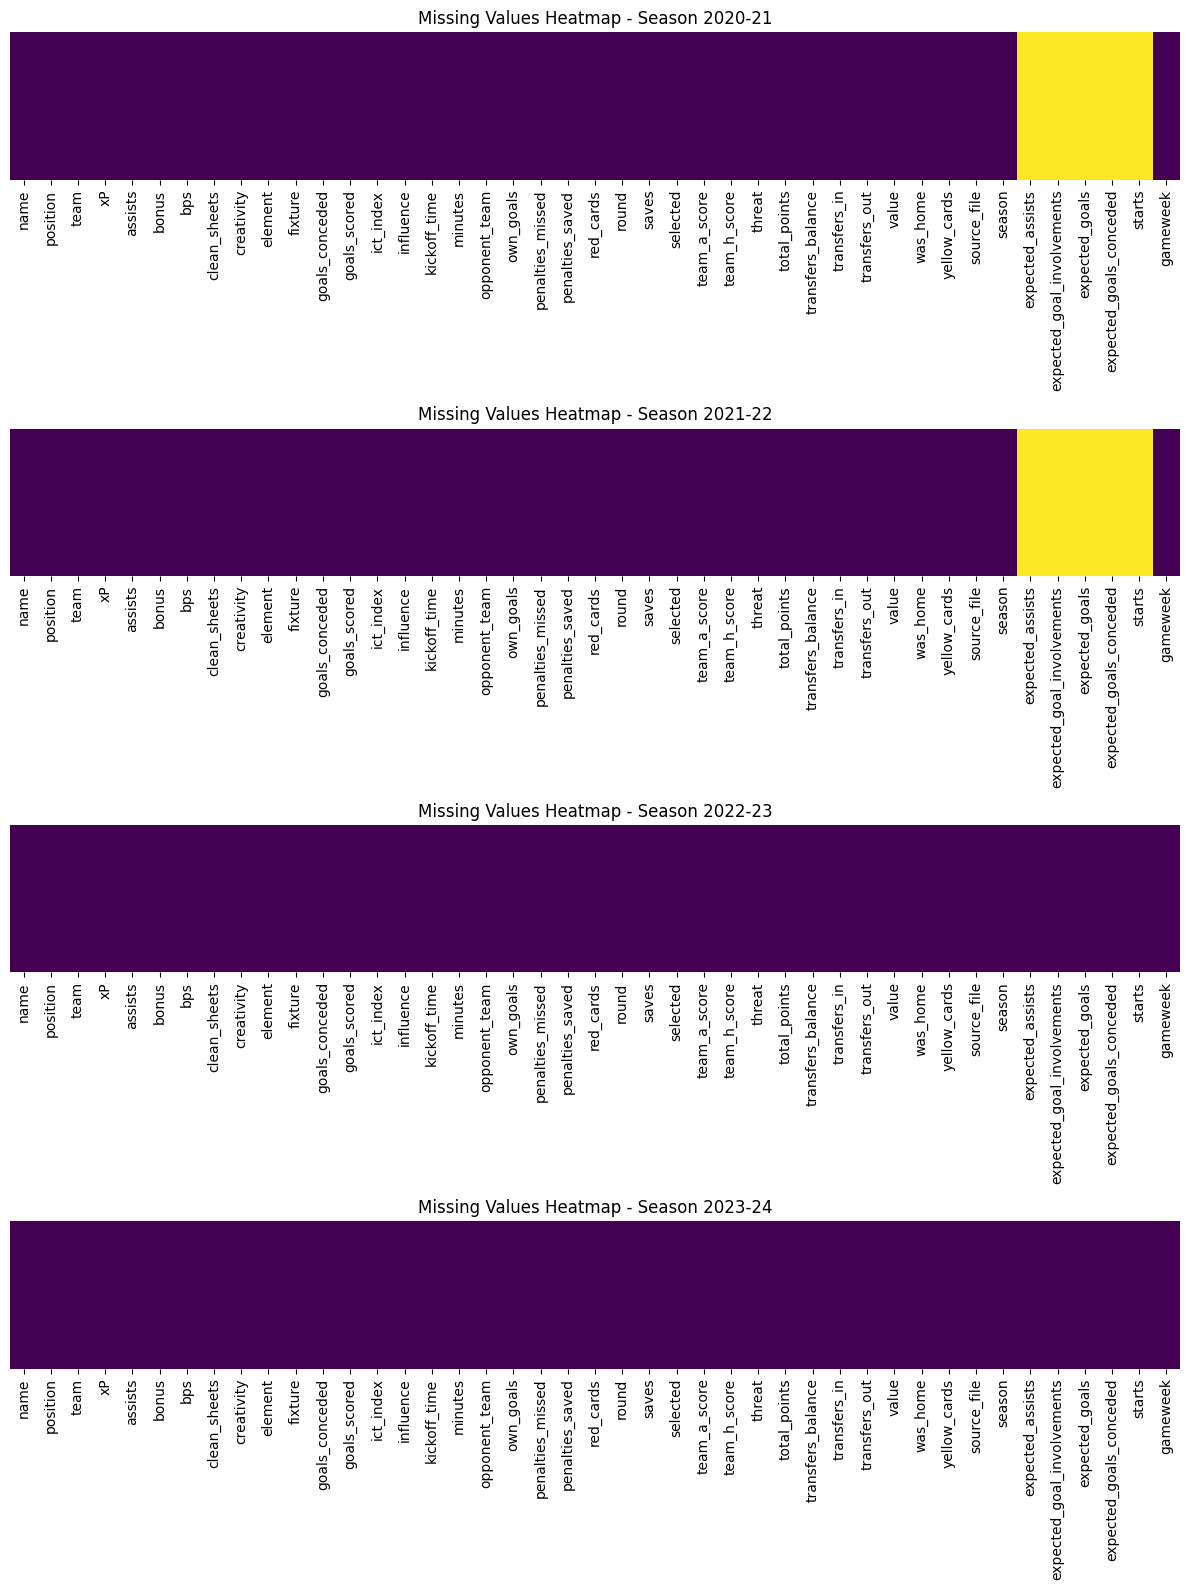

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mismap(df):
    seasons = df['season'].unique()
    
    # Create a subplot for each season
    num_seasons = len(seasons)
    fig, axes = plt.subplots(num_seasons, 1, figsize=(12, num_seasons * 4))
    
    if num_seasons == 1:
        axes = [axes]  

    for ax, season in zip(axes, seasons):
        season_df = df[df['season'] == season]
        sns.heatmap(season_df.isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=ax)
        ax.set_title(f'Missing Values Heatmap - Season {season}')
    
    plt.tight_layout()
    plt.show()

plot_mismap(df_gameweek)

### Optimisation

In [5]:
cols_opt = [
    "name",
    "position",
    "team",
    "xP",
    "value",
    "gameweek",
    "season",
    "total_points"
    ]

df_optimisation = df_gameweek[cols_opt].sort_values(by=['gameweek', 'season'], ascending=[True, True])
print(df_optimisation)

                           name position           team   xP value  gameweek  \
10936            Aaron Connolly      FWD       Brighton  0.5    55         1   
10937           Aaron Cresswell      DEF       West Ham  2.1    50         1   
10938                Aaron Mooy      MID       Brighton  0.0    50         1   
10939            Aaron Ramsdale       GK  Sheffield Utd  2.5    50         1   
10940        Abdoulaye Doucouré      MID        Everton  1.3    55         1   
...                         ...      ...            ...  ...   ...       ...   
55637              Oliver Skipp      MID          Spurs  2.0    43        38   
55638            Ryan Sessegnon      DEF          Spurs  0.0    44        38   
55639              Ashley Young      DEF    Aston Villa  1.0    43        38   
55640  Jeremy Sarmiento Morante      MID       Brighton  0.0    45        38   
55641            Philip Billing      MID    Bournemouth  1.1    50        38   

        season total_points  
10936  20

In [6]:
# Extract unique values
players = df_optimisation['name'].unique()
gameweeks = df_optimisation['gameweek'].unique()
seasons = df_optimisation['season'].unique()

# Create mappings for player indices, gameweek indices, and season indices
player_indices = {name: i+1 for i, name in enumerate(players)}
gameweek_indices = {gw: i+1 for i, gw in enumerate(gameweeks)}
season_indices = {season: i+1 for i, season in enumerate(seasons)}

In [7]:
print(player_indices)
print(gameweek_indices)
print(season_indices)

{'Aaron Connolly': 1, 'Aaron Cresswell': 2, 'Aaron Mooy': 3, 'Aaron Ramsdale': 4, 'Abdoulaye Doucouré': 5, 'Aboubakar Kamara': 6, 'Adama Traoré': 7, 'Adam Forshaw': 8, 'Adam Lallana': 9, 'Adam Webster': 10, 'Adrien Silva': 11, 'Adrián San Miguel del Castillo': 12, 'Ahmed El-Sayed Hegazy': 13, 'Ainsley Maitland-Niles': 14, 'Albian Ajeti': 15, 'Aleksandar Mitrović': 16, 'Alexandre Lacazette': 17, 'Alexis Mac Allister': 18, 'Alex Iwobi': 19, 'Alex McCarthy': 20, 'Alex Oxlade-Chamberlain': 21, 'Alfie Mawson': 22, 'Alireza Jahanbakhsh': 23, 'Alisson Ramses Becker': 24, 'Allan Marques Loureiro': 25, 'Allan Saint-Maximin': 26, 'Alphonse Areola': 27, 'Andreas Christensen': 28, 'Andrew Robertson': 29, 'Andriy Yarmolenko': 30, 'Andros Townsend': 31, 'André Filipe Tavares Gomes': 32, 'André-Frank Zambo Anguissa': 33, 'Andy Carroll': 34, 'Angelo Ogbonna': 35, 'Angus Gunn': 36, 'Anthony Gordon': 37, 'Anthony Knockaert': 38, 'Antonee Robinson': 39, 'Antonio Rüdiger': 40, 'Arthur Masuaku': 41, 'Ayoze

In [8]:
# Define the Pyomo model
model = pyo.ConcreteModel()

# Sets
model.players = pyo.Set(initialize=player_indices.values())
model.gameweeks = pyo.Set(initialize=gameweek_indices.values())
model.seasons = pyo.Set(initialize=season_indices.values())

# Parameters
model.cost = pyo.Param(model.players, initialize={player_indices[row['name']]: row['value'] for _, row in df_optimisation.iterrows()})
model.predicted_points = pyo.Param(model.players, model.gameweeks, model.seasons, 
                                   initialize={(player_indices[row['name']], gameweek_indices[row['gameweek']], season_indices[row['season']]): row['xP'] 
                                               for _, row in df_optimisation.iterrows()},
                                   default=0, within=pyo.Reals)
model.position = pyo.Param(model.players, initialize={player_indices[row['name']]: row['position'] for _, row in df_optimisation.iterrows()})
model.team = pyo.Param(model.players, initialize={player_indices[row['name']]: row['team'] for _, row in df_optimisation.iterrows()})

# Decision Variables
model.x = pyo.Var(model.players, model.gameweeks, model.seasons, domain=pyo.Binary)  # 1 if player is in the squad for a gameweek, 0 otherwise
model.transfers_in = pyo.Var(model.players, model.gameweeks, model.seasons, domain=pyo.Binary)  # 1 if player is transferred in, 0 otherwise
model.transfers_out = pyo.Var(model.players, model.gameweeks, model.seasons, domain=pyo.Binary)  # 1 if player is transferred out, 0 otherwise

# Objective Function: Maximize total projected points over gameweeks and seasons
model.objective = pyo.Objective(
    expr=sum(model.predicted_points[p, gw, s] * model.x[p, gw, s] for p in model.players for gw in model.gameweeks for s in model.seasons)
    - 4 * sum(model.transfers_in[p, gw, s] + model.transfers_out[p, gw, s] for p in model.players for gw in model.gameweeks for s in model.seasons)  # Penalize extra transfers
    + 4 * sum(model.transfers_out[p, 1, s] for p in model.players for s in model.seasons),  # Compensate for no initial transfers out
    sense=pyo.maximize
)

'Any'. The default domain for Param objects is 'Any'.  However, we will be
changing that default to 'Reals' in the future.  If you really intend the
domain of this Paramto be 'Any', you can suppress this warning by explicitly
specifying 'within=Any' to the Param constructor.  (deprecated in 5.6.9, will
be removed in (or after) 6.0) (called from
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-
packages/pyomo/core/base/indexed_component.py:714)
The default domain for Param objects is 'Any'.  However, we will be changing
that default to 'Reals' in the future.  If you really intend the domain of
this Paramto be 'Any', you can suppress this warning by explicitly specifying
'within=Any' to the Param constructor. (deprecated in 5.6.9, will be removed
in (or after) 6.0) (called from
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-
packages/pyomo/core/base/indexed_component.py:714)


In [9]:
# Delete existing components if they exist
model.del_component('budget_constraint')
model.del_component('squad_size_constraint')
model.del_component('position_constraints')
model.del_component('team_constraints')
model.del_component('transfer_constraints')
model.del_component('link_transfers')

# Budget constraint for each gameweek in each season
def budget_constraint_rule(model, gw, s):
    return sum(model.cost[p] * model.x[p, gw, s] for p in model.players) <= 1000
model.budget_constraint = pyo.Constraint(model.gameweeks, model.seasons, rule=budget_constraint_rule)

# Squad size constraint for each gameweek in each season
def squad_size_constraint_rule(model, gw, s):
    return sum(model.x[p, gw, s] for p in model.players) == 15
model.squad_size_constraint = pyo.Constraint(model.gameweeks, model.seasons, rule=squad_size_constraint_rule)

# Position constraints for each gameweek in each season
def position_constraints_rule(model, gw, s):
    yield sum(model.x[p, gw, s] for p in model.players if model.position[p] == 'GK') == 2
    yield sum(model.x[p, gw, s] for p in model.players if model.position[p] == 'DEF') == 5
    yield sum(model.x[p, gw, s] for p in model.players if model.position[p] == 'MID') == 5
    yield sum(model.x[p, gw, s] for p in model.players if model.position[p] == 'FWD') == 3

model.position_constraints = pyo.ConstraintList()
for gw in model.gameweeks:
    for s in model.seasons:
        for constraint in position_constraints_rule(model, gw, s):
            model.position_constraints.add(constraint)

# Team limits constraint for each gameweek in each season
def team_constraints_rule(model, gw, s):
    for team in df_optimisation['team'].unique():
        yield sum(model.x[p, gw, s] for p in model.players if model.team[p] == team) <= 3

model.team_constraints = pyo.ConstraintList()
for gw in model.gameweeks:
    for s in model.seasons:
        for constraint in team_constraints_rule(model, gw, s):
            model.team_constraints.add(constraint)

# Transfer constraints for each gameweek in each season
def transfer_constraints_rule(model, gw, s):
    if gw == 1:
        # No transfers before the first gameweek
        return
    else:
        yield sum(model.transfers_in[p, gw, s] for p in model.players) - sum(model.transfers_out[p, gw, s] for p in model.players) == 0
        yield sum(model.transfers_in[p, gw, s] for p in model.players) <= 1 + 4  # 1 free transfer, additional transfers cost 4 points each

model.transfer_constraints = pyo.ConstraintList()
for gw in model.gameweeks:
    for s in model.seasons:
        for constraint in transfer_constraints_rule(model, gw, s):
            model.transfer_constraints.add(constraint)

# Link transfers to squad changes for each gameweek in each season
def link_transfers_rule(model, p, gw, s):
    if gw == 1:
        return model.x[p, gw, s] == 1  # Initial squad selection
    else:
        return model.x[p, gw, s] == model.x[p, gw-1, s] + model.transfers_in[p, gw, s] - model.transfers_out[p, gw, s]

model.link_transfers = pyo.Constraint(model.players, model.gameweeks, model.seasons, rule=link_transfers_rule)

In [10]:
# Solve the model
solver = pyo.SolverFactory('cbc')
results = solver.solve(model, tee=True)

# Display the results
for s in model.seasons:
    for gw in model.gameweeks:
        selected_players = [p for p in model.players if pyo.value(model.x[p, gw, s]) > 0.5]
        transfers_in = [p for p in model.players if pyo.value(model.transfers_in[p, gw, s]) > 0.5]
        transfers_out = [p for p in model.players if pyo.value(model.transfers_out[p, gw, s]) > 0.5]
        print(f"Season {s}, Gameweek {gw}:")
        print("Selected players:")
        print(df_optimisation[df_optimisation['name'].isin([players[p-1] for p in selected_players])][['name', 'team', 'position', 'value', 'gameweek', 'season', 'total_points']])
        print("Transfers in:")
        print(df_optimisation[df_optimisation['name'].isin([players[p-1] for p in transfers_in])][['name', 'team', 'position', 'value', 'gameweek', 'season', 'total_points']])
        print("Transfers out:")
        print(df_optimisation[df_optimisation['name'].isin([players[p-1] for p in transfers_out])][['name', 'team', 'position', 'value', 'gameweek', 'season', 'total_points']])
        print()

ERROR: Solver (cbc) returned non-zero return code (-6)
ERROR: See the solver log above for diagnostic information.


ApplicationError: Solver (cbc) did not exit normally